In [ ]:
# Add scripts to path and fix working directory
import sys
import os
from pathlib import Path

# Set project root explicitly
project_root = Path(__file__).parent.parent.parent if '__file__' in locals() else Path("/home/Plutonium/Documents/BioinfoMidterm")

os.chdir(project_root)
sys.path.insert(0, str(project_root / "scripts"))

print(f"Working directory: {os.getcwd()}")

from config import PATHS, ML, POPULATIONS
from utils import (
    vcf_to_numeric_matrix,
    add_population_labels,
    ensure_dir,
    run_bcftools_command,
    variants_to_bed_file,
)
from ml_training import (
    load_ml_data,
    train_random_forest,
    train_xgboost,
    train_logistic_regression,
    evaluate_model,
    cross_validate_model,
    get_feature_importances,
    train_on_top_features,
    save_model,
    run_full_pipeline,
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Configuration
print("\nML Configuration:")
print(f"  Test size: {ML.TEST_SIZE}")
print(f"  Random state: {ML.RANDOM_STATE}")
print(f"  RF estimators: {ML.RF_N_ESTIMATORS}")
print(f"  XGB estimators: {ML.XGB_N_ESTIMATORS}")
print(f"  Top N features: {ML.TOP_N_FEATURES}")

Working directory: /home/Plutonium/Documents/BioinfoMidterm
ML Configuration:
  Test size: 0.2
  Random state: 42
  RF estimators: 200
  XGB estimators: 200
  Top N features: 25


## Step 1: Prepare ML Data

Check if ML data exists. If not, run VCF conversion pipeline to create it.

In [5]:
# Check if ML data exists
import os

ML_DATA_PATH = str(PATHS.ML_DATA)

if os.path.exists(ML_DATA_PATH):
    print(f"✓ ML data exists: {ML_DATA_PATH}")
    NEED_VCF_CONVERSION = False
else:
    print("✗ ML data not found. Will run VCF conversion steps.")
    NEED_VCF_CONVERSION = True

✓ ML data exists: 1000genomes/vcf/vcf_numeric_transposed_with_population.csv


## Step 1a: VCF to Numeric Conversion (if needed)

This section converts VCF data to a numeric genotype matrix suitable for ML.

**Pipeline:**
1. Extract selected SNPs from VCF using BED coordinates
2. Filter to biallelic SNPs only
3. Convert genotypes to numeric (0/1/2)
4. Transpose so samples are rows
5. Add population labels

In [6]:
# Step 1: Extract SNPs from VCF using BED file
if NEED_VCF_CONVERSION:
    from utils import run_bcftools_command, variants_to_bed_file
    
    # Paths
    TOP_SNPS_FILE = str(PATHS.TOP_SNPS_FILE)
    TOP_SNPS_BED = str(PATHS.TOP_SNPS_BED)
    VCF_FILE = str(PATHS.VCF_FILE)
    FILTERED_VCF = str(PATHS.VCF_DIR / "filtered.vcf.gz")
    SAMPLES_LIST = str(PATHS.EAS_SAMPLES_LIST)
    
    # Convert SNP IDs to BED format (if not exists)
    if not os.path.exists(TOP_SNPS_BED):
        print("Converting SNP IDs to BED format...")
        variants_to_bed_file(TOP_SNPS_FILE, TOP_SNPS_BED)
    else:
        print(f"✓ BED file exists: {TOP_SNPS_BED}")
    
    # Extract SNPs from VCF
    print("\nExtracting SNPs from VCF...")
    run_bcftools_command([
        "view",
        "-S", SAMPLES_LIST,
        "-R", TOP_SNPS_BED,
        "-Oz",
        "-o", FILTERED_VCF,
        VCF_FILE
    ])
    print(f"✓ Created filtered VCF: {FILTERED_VCF}")
else:
    print("Skipping VCF extraction - ML data already exists.")

Skipping VCF extraction - ML data already exists.


In [7]:
# Step 2: Filter to biallelic SNPs only
if NEED_VCF_CONVERSION:
    FILTERED_VCF = str(PATHS.VCF_DIR / "filtered.vcf.gz")
    SNPS_ONLY_VCF = str(PATHS.VCF_DIR / "filtered_snps_only.vcf")
    SNPS_FINAL_VCF = str(PATHS.VCF_DIR / "filtered_snps_only_final.vcf")
    
    print("Filtering to biallelic SNPs only...")
    
    # Filter ALT to single nucleotide
    run_bcftools_command([
        "view",
        "-i", 'ALT ~ "^[ATGC]$"',
        "-o", SNPS_ONLY_VCF,
        FILTERED_VCF
    ])
    
    # Filter REF to single nucleotide
    run_bcftools_command([
        "view",
        "-i", 'REF ~ "^[ATGC]$"',
        "-o", SNPS_FINAL_VCF,
        SNPS_ONLY_VCF
    ])
    
    print(f"✓ Created biallelic SNP VCF: {SNPS_FINAL_VCF}")
else:
    print("Skipping SNP filtering - ML data already exists.")

Skipping SNP filtering - ML data already exists.


In [8]:
# Step 3: Clean VCF (remove ## header lines) and convert to numeric matrix
if NEED_VCF_CONVERSION:
    SNPS_FINAL_VCF = str(PATHS.VCF_DIR / "filtered_snps_only_final.vcf")
    CLEAN_VCF = str(PATHS.VCF_DIR / "snps_only_clean.vcf")
    NUMERIC_CSV = str(PATHS.VCF_DIR / "vcf_numeric_transposed.csv")
    
    # Remove ## meta lines, keep #CHROM header and data
    print("Cleaning VCF headers...")
    with open(SNPS_FINAL_VCF, 'r') as fin, open(CLEAN_VCF, 'w') as fout:
        for line in fin:
            if not line.startswith('##'):
                fout.write(line)
    print(f"✓ Created clean VCF: {CLEAN_VCF}")
    
    # Convert to numeric matrix using utility function
    print("\nConverting VCF to numeric matrix...")
    numeric_df = vcf_to_numeric_matrix(CLEAN_VCF, NUMERIC_CSV, verbose=True)
else:
    print("Skipping VCF cleaning - ML data already exists.")

Skipping VCF cleaning - ML data already exists.


In [9]:
# Step 4: Add population labels
if NEED_VCF_CONVERSION:
    NUMERIC_CSV = str(PATHS.VCF_DIR / "vcf_numeric_transposed.csv")
    POPULATION_CSV = str(PATHS.EAS_SAMPLES_CSV)
    ML_DATA_OUTPUT = str(PATHS.ML_DATA)
    
    print("Adding population labels...")
    final_df = add_population_labels(NUMERIC_CSV, POPULATION_CSV, ML_DATA_OUTPUT, verbose=True)
    
    print(f"\n✓ ML data created successfully!")
    print(f"  Output: {ML_DATA_OUTPUT}")
    print(f"  Shape: {final_df.shape}")
    print(f"  Populations: {final_df['pop'].value_counts().to_dict()}")
    
    # Update path for downstream steps
    ML_DATA_PATH = ML_DATA_OUTPUT
else:
    print("Skipping population labeling - ML data already exists.")

Skipping population labeling - ML data already exists.


## Step 1b: Load ML Data

Load the prepared numeric matrix with population labels.

In [10]:
# Load ML data
X, y, feature_names = load_ml_data(
    ML_DATA_PATH,
    target_column="pop",
    verbose=True,
)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())

Loading data from: 1000genomes/vcf/vcf_numeric_transposed_with_population.csv
  Samples: 306
  Features: 2637
  Classes: 3 ({'JPT': 104, 'CHB': 103, 'KHV': 99})

Feature matrix shape: (306, 2637)
Target distribution:
pop
JPT    104
CHB    103
KHV     99
Name: count, dtype: int64


In [11]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Classes: {le.classes_}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=ML.TEST_SIZE,
    stratify=y,
    random_state=ML.RANDOM_STATE,
)

y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Classes: ['CHB' 'JPT' 'KHV']

Train set: 244 samples
Test set: 62 samples


## Step 2: Train Random Forest

In [12]:
# Train Random Forest
rf = train_random_forest(
    X_train, y_train,
    n_estimators=ML.RF_N_ESTIMATORS,
    verbose=True,
)


Training Random Forest...
  n_estimators: 200
  max_depth: None
  Training complete!


In [13]:
# Evaluate Random Forest
rf_results = evaluate_model(rf, X_test, y_test, "Random Forest", verbose=True)


Random Forest EVALUATION
Accuracy: 1.0000
F1 (macro): 1.0000
F1 (weighted): 1.0000

Classification Report:
              precision    recall  f1-score   support

         CHB       1.00      1.00      1.00        21
         JPT       1.00      1.00      1.00        21
         KHV       1.00      1.00      1.00        20

    accuracy                           1.00        62
   macro avg       1.00      1.00      1.00        62
weighted avg       1.00      1.00      1.00        62



In [14]:
# Cross-validation
from sklearn.ensemble import RandomForestClassifier

rf_cv = cross_validate_model(
    RandomForestClassifier(n_estimators=ML.RF_N_ESTIMATORS, random_state=ML.RANDOM_STATE),
    X, y,
    cv=ML.CV_FOLDS,
    model_name="Random Forest",
)


Cross-validating Random Forest (5-fold)...
  CV Accuracy: 0.9607 (+/- 0.0986)


## Step 3: Train XGBoost

In [15]:
# Train XGBoost
try:
    xgb_clf = train_xgboost(
        X_train, y_train_encoded,
        n_estimators=ML.XGB_N_ESTIMATORS,
        max_depth=ML.XGB_MAX_DEPTH,
        learning_rate=ML.XGB_LEARNING_RATE,
        verbose=True,
    )
    
    # Evaluate
    xgb_results = evaluate_model(xgb_clf, X_test, y_test_encoded, "XGBoost", verbose=True)
except ImportError as e:
    print(f"XGBoost not available: {e}")
    xgb_clf = None


Training XGBoost...
  n_estimators: 200
  max_depth: 6
  learning_rate: 0.1


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [18:05:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Training complete!

XGBoost EVALUATION
Accuracy: 0.9677
F1 (macro): 0.9679
F1 (weighted): 0.9677

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.95      0.95      0.95        21
           2       0.95      1.00      0.98        20

    accuracy                           0.97        62
   macro avg       0.97      0.97      0.97        62
weighted avg       0.97      0.97      0.97        62



## Step 4: Train Logistic Regression

In [16]:
# Train Logistic Regression
lr = train_logistic_regression(
    X_train, y_train,
    max_iter=ML.LR_MAX_ITER,
    verbose=True,
)

# Evaluate
lr_results = evaluate_model(lr, X_test, y_test, "Logistic Regression", verbose=True)


Training Logistic Regression...
  max_iter: 1000
  solver: lbfgs


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Training complete!

Logistic Regression EVALUATION
Accuracy: 1.0000
F1 (macro): 1.0000
F1 (weighted): 1.0000

Classification Report:
              precision    recall  f1-score   support

         CHB       1.00      1.00      1.00        21
         JPT       1.00      1.00      1.00        21
         KHV       1.00      1.00      1.00        20

    accuracy                           1.00        62
   macro avg       1.00      1.00      1.00        62
weighted avg       1.00      1.00      1.00        62



## Step 5: Compare Models

In [17]:
# Collect results
results = {
    "Random Forest": rf_results,
    "Logistic Regression": lr_results,
}
if xgb_clf is not None:
    results["XGBoost"] = xgb_results

# Comparison table
comparison_df = pd.DataFrame({
    "Model": results.keys(),
    "Accuracy": [r["accuracy"] for r in results.values()],
    "F1 (macro)": [r["f1_macro"] for r in results.values()],
    "F1 (weighted)": [r["f1_weighted"] for r in results.values()],
})

print("Model Comparison:")
display(comparison_df)

Model Comparison:


,Model,Accuracy,F1 (macro),F1 (weighted)
0,Random Forest,1.000000,1.000000,1.000000
1,Logistic Regression,1.000000,1.000000,1.000000
2,XGBoost,0.967742,0.967867,0.967742


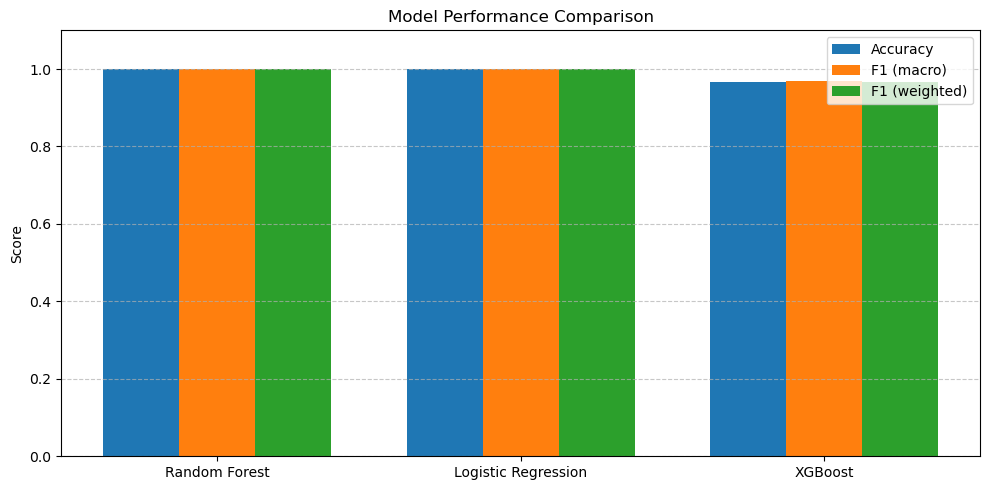

In [18]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(comparison_df))
width = 0.25

ax.bar(x - width, comparison_df["Accuracy"], width, label="Accuracy")
ax.bar(x, comparison_df["F1 (macro)"], width, label="F1 (macro)")
ax.bar(x + width, comparison_df["F1 (weighted)"], width, label="F1 (weighted)")

ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")
ax.set_xticks(x)
ax.set_xticklabels(comparison_df["Model"])
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Step 6: Confusion Matrices

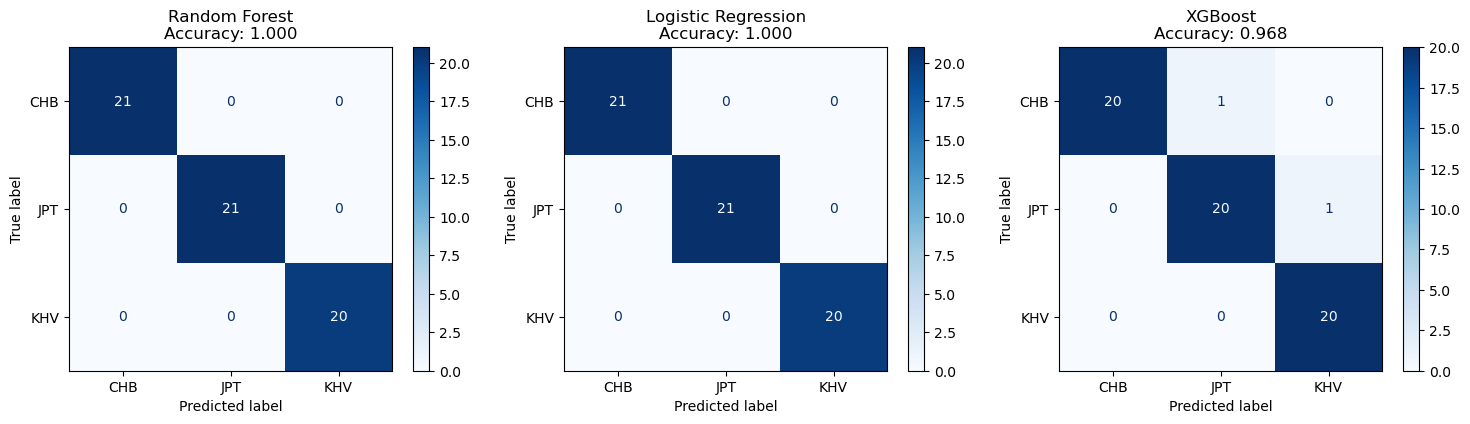

In [19]:
# Plot confusion matrices
fig, axes = plt.subplots(1, len(results), figsize=(5*len(results), 4))

if len(results) == 1:
    axes = [axes]

for ax, (name, result) in zip(axes, results.items()):
    ConfusionMatrixDisplay(
        result["confusion_matrix"],
        display_labels=le.classes_,
    ).plot(ax=ax, cmap="Blues")
    ax.set_title(f"{name}\nAccuracy: {result['accuracy']:.3f}")

plt.tight_layout()
plt.show()

## Step 7: Feature Importance Analysis

In [20]:
# Get feature importances from Random Forest
rf_importance = get_feature_importances(
    rf, feature_names,
    top_n=ML.TOP_N_FEATURES,
    verbose=True,
)


Top 25 Features by Importance:
  11:61548559: 0.011166
  3:100365528: 0.010633
  17:40956277: 0.009975
  1:22315762: 0.005896
  14:96938945: 0.004887
  16:67913222: 0.004628
  9:133578385: 0.004385
  4:17813761: 0.004127
  1:569204: 0.004085
  18:18518431: 0.003785
  8:102130291: 0.003439
  17:725743: 0.003390
  1:80875078: 0.003309
  3:172774448: 0.003190
  18:52821467: 0.002873
  12:128054516: 0.002854
  8:74175076: 0.002775
  5:120686518: 0.002715
  11:101307853: 0.002669
  5:68662421: 0.002666
  2:82025430: 0.002594
  7:35674854: 0.002528
  16:89684324: 0.002461
  4:101002868: 0.002397
  7:348498: 0.002291


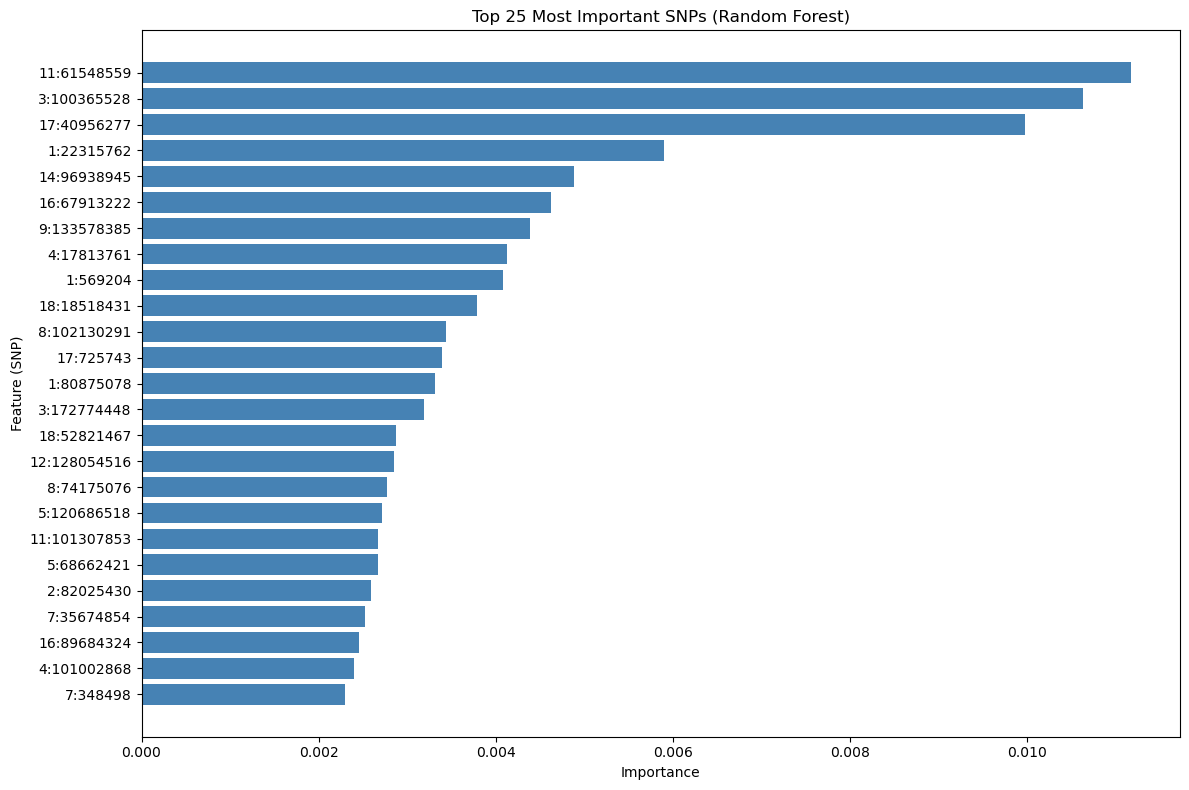

In [21]:
# Visualize top features
top_n = ML.TOP_N_FEATURES
top_features = rf_importance.head(top_n)

plt.figure(figsize=(12, 8))
plt.barh(range(top_n), top_features['importance'].values[::-1], color='steelblue')
plt.yticks(range(top_n), top_features['feature'].values[::-1])
plt.xlabel('Importance')
plt.ylabel('Feature (SNP)')
plt.title(f'Top {top_n} Most Important SNPs (Random Forest)')
plt.tight_layout()
plt.show()

## Step 8: Train on Top Features Only

In [23]:
# Train on top features
from sklearn.ensemble import RandomForestClassifier

rf_top, rf_top_results = train_on_top_features(
    RandomForestClassifier,
    X, y,
    rf_importance,
    top_n=ML.TOP_N_FEATURES,
    test_size=ML.TEST_SIZE,
    random_state=ML.RANDOM_STATE,
    n_estimators=ML.RF_N_ESTIMATORS,
)


Training on top 25 features...

RandomForestClassifier (top 25) EVALUATION
Accuracy: 0.7742
F1 (macro): 0.7750
F1 (weighted): 0.7737

Classification Report:
              precision    recall  f1-score   support

         CHB       0.67      0.76      0.71        21
         JPT       0.88      0.67      0.76        21
         KHV       0.82      0.90      0.86        20

    accuracy                           0.77        62
   macro avg       0.79      0.78      0.78        62
weighted avg       0.79      0.77      0.77        62



In [24]:
# Compare full vs top features
print("\nPerformance Comparison:")
print("="*60)
print(f"Full features ({len(feature_names)}):")
print(f"  Accuracy: {rf_results['accuracy']:.4f}")
print(f"  F1 (macro): {rf_results['f1_macro']:.4f}")
print(f"\nTop {ML.TOP_N_FEATURES} features:")
print(f"  Accuracy: {rf_top_results['accuracy']:.4f}")
print(f"  F1 (macro): {rf_top_results['f1_macro']:.4f}")


Performance Comparison:
Full features (2637):
  Accuracy: 1.0000
  F1 (macro): 1.0000

Top 25 features:
  Accuracy: 0.7742
  F1 (macro): 0.7750


### Train Multiple Models on Top Features

Compare different classifiers using only the top SNP features to find the best model for this reduced feature set.

In [35]:
# Prepare top features data
top_feature_names = rf_importance.head(ML.TOP_N_FEATURES)['feature'].tolist()
X_top = X[top_feature_names]

# Split with top features only
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
    X_top, y,
    test_size=ML.TEST_SIZE,
    stratify=y,
    random_state=ML.RANDOM_STATE,
)

y_train_top_encoded = le.transform(y_train_top)
y_test_top_encoded = le.transform(y_test_top)

print(f"Top {ML.TOP_N_FEATURES} Features Dataset:")
print(f"  Train: {X_train_top.shape}")
print(f"  Test: {X_test_top.shape}")
print(f"  Features: {top_feature_names[:5]}...")

Top 25 Features Dataset:
  Train: (244, 25)
  Test: (62, 25)
  Features: ['11:61548559', '3:100365528', '17:40956277', '1:22315762', '14:96938945']...


In [36]:
# Train multiple models on top features
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import xgboost as xgb

# Define models to compare
top_feature_models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=ML.RF_N_ESTIMATORS, 
        random_state=ML.RANDOM_STATE,
        n_jobs=-1
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=ML.XGB_N_ESTIMATORS,
        max_depth=ML.XGB_MAX_DEPTH,
        learning_rate=ML.XGB_LEARNING_RATE,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=ML.RANDOM_STATE,
        n_jobs=-1
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=ML.LR_MAX_ITER,
        multi_class='multinomial',
        solver='lbfgs',
        random_state=ML.RANDOM_STATE,
        n_jobs=-1
    ),
    'SVM (RBF)': SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        random_state=ML.RANDOM_STATE
    ),
    'SVM (Linear)': SVC(
        kernel='linear',
        C=1.0,
        random_state=ML.RANDOM_STATE
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5,
        n_jobs=-1
    ),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=ML.RANDOM_STATE
    ),
    'AdaBoost': AdaBoostClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=ML.RANDOM_STATE
    ),
    'MLP Neural Net': MLPClassifier(
        hidden_layer_sizes=(100, 50),
        max_iter=500,
        random_state=ML.RANDOM_STATE,
        early_stopping=True
    ),
}

print(f"Training {len(top_feature_models)} models on top {ML.TOP_N_FEATURES} features...")
print("="*60)

Training 10 models on top 25 features...


In [ ]:
# Train and evaluate all models
top_feature_results = {}

for model_name, model in top_feature_models.items():
    print(f"\n>>> Training {model_name}...")
    
    # XGBoost and MLP need encoded labels
    if 'XGBoost' in model_name or 'MLP' in model_name:
        model.fit(X_train_top, y_train_top_encoded)
        y_pred = model.predict(X_test_top)
        acc = accuracy_score(y_test_top_encoded, y_pred)
        f1 = f1_score(y_test_top_encoded, y_pred, average='macro')
        f1_weighted = f1_score(y_test_top_encoded, y_pred, average='weighted')
        cm = confusion_matrix(y_test_top_encoded, y_pred)
    else:
        model.fit(X_train_top, y_train_top)
        y_pred = model.predict(X_test_top)
        acc = accuracy_score(y_test_top, y_pred)
        f1 = f1_score(y_test_top, y_pred, average='macro')
        f1_weighted = f1_score(y_test_top, y_pred, average='weighted')
        cm = confusion_matrix(y_test_top, y_pred)
    
    top_feature_results[model_name] = {
        'model': model,
        'accuracy': acc,
        'f1_macro': f1,
        'f1_weighted': f1_weighted,
        'y_pred': y_pred,
        'confusion_matrix': cm,
    }
    
    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1 (macro): {f1:.4f}")

print("\n" + "="*60)
print("Training complete!")


>>> Training Random Forest...
    Accuracy: 0.7742
    F1 (macro): 0.7768

>>> Training XGBoost...
    Accuracy: 0.7742
    F1 (macro): 0.7766

>>> Training Logistic Regression...


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [18:33:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


    Accuracy: 0.8065
    F1 (macro): 0.8095

>>> Training SVM (RBF)...
    Accuracy: 0.7903
    F1 (macro): 0.7949

>>> Training SVM (Linear)...
    Accuracy: 0.7742
    F1 (macro): 0.7789

>>> Training K-Nearest Neighbors...
    Accuracy: 0.7581
    F1 (macro): 0.7586

>>> Training Naive Bayes...
    Accuracy: 0.7742
    F1 (macro): 0.7625

>>> Training Gradient Boosting...
    Accuracy: 0.7581
    F1 (macro): 0.7606

>>> Training AdaBoost...
    Accuracy: 0.7419
    F1 (macro): 0.7455

>>> Training MLP Neural Net...


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# Results comparison table
results_df = pd.DataFrame([
    {
        'Model': name,
        'Accuracy': r['accuracy'],
        'F1 (macro)': r['f1_macro'],
        'F1 (weighted)': r['f1_weighted'],
    }
    for name, r in top_feature_results.items()
]).sort_values('Accuracy', ascending=False)

print(f"\nModel Comparison on Top {ML.TOP_N_FEATURES} Features:")
print("="*70)
display(results_df.reset_index(drop=True))

# Best model
best_top_model = results_df.iloc[0]
print(f"\n🏆 Best Model: {best_top_model['Model']}")
print(f"   Accuracy: {best_top_model['Accuracy']:.4f}")
print(f"   F1 (macro): {best_top_model['F1 (macro)']:.4f}")

In [ ]:
# Visualize model comparison on top features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sort by accuracy for plotting
sorted_results = sorted(top_feature_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
model_names_sorted = [m[0] for m in sorted_results]
accuracies_sorted = [m[1]['accuracy'] for m in sorted_results]
f1_sorted = [m[1]['f1_macro'] for m in sorted_results]

# Plot 1: Horizontal bar chart - Accuracy ranking
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.9, len(sorted_results)))
bars = axes[0, 0].barh(model_names_sorted[::-1], accuracies_sorted[::-1], color=colors[::-1], edgecolor='black')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title(f'Model Accuracy Ranking (Top {ML.TOP_N_FEATURES} Features)')
axes[0, 0].set_xlim(0, 1.05)
axes[0, 0].grid(axis='x', linestyle='--', alpha=0.7)
for bar, acc in zip(bars, accuracies_sorted[::-1]):
    axes[0, 0].text(acc + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{acc:.3f}', ha='left', va='center', fontsize=9)

# Plot 2: Grouped bar chart - Accuracy vs F1
x_pos = np.arange(len(model_names_sorted))
width = 0.35
axes[0, 1].bar(x_pos - width/2, accuracies_sorted, width, label='Accuracy', color='steelblue', alpha=0.8)
axes[0, 1].bar(x_pos + width/2, f1_sorted, width, label='F1 (macro)', color='coral', alpha=0.8)
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Accuracy vs F1 Score Comparison')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(model_names_sorted, rotation=45, ha='right', fontsize=8)
axes[0, 1].legend()
axes[0, 1].set_ylim(0, 1.1)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: Confusion matrices for top 3 models (as subplots)
top_3_models = sorted_results[:3]
for idx, (name, result) in enumerate(top_3_models):
    if idx == 0:
        ax_cm = axes[1, 0]
    elif idx == 1:
        # Create inset for 2nd best
        continue
    elif idx == 2:
        continue
    
    cm = result['confusion_matrix']
    im = ax_cm.imshow(cm, cmap='Blues')
    ax_cm.set_title(f'Best Model: {name}\n(Accuracy: {result["accuracy"]:.4f})')
    ax_cm.set_xlabel('Predicted')
    ax_cm.set_ylabel('Actual')
    ax_cm.set_xticks(range(len(le.classes_)))
    ax_cm.set_yticks(range(len(le.classes_)))
    ax_cm.set_xticklabels(le.classes_)
    ax_cm.set_yticklabels(le.classes_)
    for i in range(len(le.classes_)):
        for j in range(len(le.classes_)):
            ax_cm.text(j, i, cm[i, j], ha='center', va='center',
                      color='white' if cm[i, j] > cm.max()/2 else 'black', fontsize=14)
    plt.colorbar(im, ax=ax_cm)

# Plot 4: Box plot of scores
scores_data = []
for name in model_names_sorted:
    r = top_feature_results[name]
    scores_data.append({
        'Model': name,
        'Metric': 'Accuracy',
        'Score': r['accuracy']
    })
    scores_data.append({
        'Model': name,
        'Metric': 'F1 (macro)',
        'Score': r['f1_macro']
    })
    scores_data.append({
        'Model': name,
        'Metric': 'F1 (weighted)',
        'Score': r['f1_weighted']
    })

scores_df = pd.DataFrame(scores_data)
axes[1, 1].set_title('Score Distribution by Metric')

# Create grouped bars manually
metrics = ['Accuracy', 'F1 (macro)', 'F1 (weighted)']
x = np.arange(len(model_names_sorted))
width = 0.25
for i, metric in enumerate(metrics):
    values = [top_feature_results[m][['accuracy', 'f1_macro', 'f1_weighted'][i]] for m in model_names_sorted]
    axes[1, 1].bar(x + i*width - width, values, width, label=metric, alpha=0.8)

axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(model_names_sorted, rotation=45, ha='right', fontsize=7)
axes[1, 1].legend()
axes[1, 1].set_ylim(0, 1.1)
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Display confusion matrices for top 4 models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

top_4_models = sorted_results[:4]

for idx, (name, result) in enumerate(top_4_models):
    cm = result['confusion_matrix']
    im = axes[idx].imshow(cm, cmap='Blues')
    axes[idx].set_title(f'{name}\n(Acc: {result["accuracy"]:.3f}, F1: {result["f1_macro"]:.3f})')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xticks(range(len(le.classes_)))
    axes[idx].set_yticks(range(len(le.classes_)))
    axes[idx].set_xticklabels(le.classes_)
    axes[idx].set_yticklabels(le.classes_)
    for i in range(len(le.classes_)):
        for j in range(len(le.classes_)):
            axes[idx].text(j, i, cm[i, j], ha='center', va='center',
                          color='white' if cm[i, j] > cm.max()/2 else 'black', fontsize=12)

plt.suptitle(f'Confusion Matrices - Top 4 Models (Top {ML.TOP_N_FEATURES} Features)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

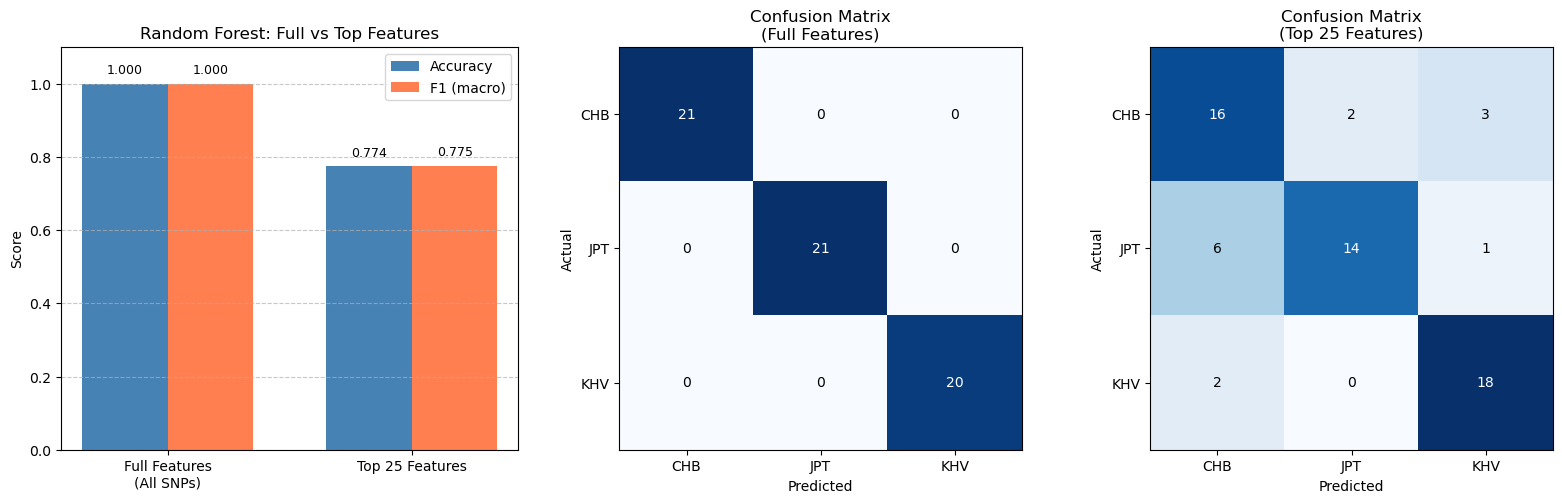

In [28]:
# Visualize Full vs Top Features Performance Comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Bar chart: Accuracy comparison
models = ['Full Features\n(All SNPs)', f'Top {ML.TOP_N_FEATURES} Features']
accuracies = [rf_results['accuracy'], rf_top_results['accuracy']]
f1_scores = [rf_results['f1_macro'], rf_top_results['f1_macro']]

x_pos = np.arange(len(models))
width = 0.35

axes[0].bar(x_pos - width/2, accuracies, width, label='Accuracy', color='steelblue')
axes[0].bar(x_pos + width/2, f1_scores, width, label='F1 (macro)', color='coral')
axes[0].set_ylabel('Score')
axes[0].set_title('Random Forest: Full vs Top Features')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].set_ylim(0, 1.1)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, (acc, f1) in enumerate(zip(accuracies, f1_scores)):
    axes[0].text(i - width/2, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, f1 + 0.02, f'{f1:.3f}', ha='center', va='bottom', fontsize=9)

# Confusion matrix for full features
from sklearn.metrics import confusion_matrix
y_pred_full = rf.predict(X_test)
cm_full = confusion_matrix(y_test, y_pred_full)
im1 = axes[1].imshow(cm_full, cmap='Blues')
axes[1].set_title('Confusion Matrix\n(Full Features)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticks(range(len(le.classes_)))
axes[1].set_yticks(range(len(le.classes_)))
axes[1].set_xticklabels(le.classes_)
axes[1].set_yticklabels(le.classes_)
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        axes[1].text(j, i, cm_full[i, j], ha='center', va='center', 
                    color='white' if cm_full[i, j] > cm_full.max()/2 else 'black')

# Confusion matrix for top features
X_top = X[rf_importance.head(ML.TOP_N_FEATURES)['feature'].tolist()]
X_test_top = X_test[rf_importance.head(ML.TOP_N_FEATURES)['feature'].tolist()]
y_pred_top = rf_top.predict(X_test_top)
cm_top = confusion_matrix(y_test, y_pred_top)
im2 = axes[2].imshow(cm_top, cmap='Blues')
axes[2].set_title(f'Confusion Matrix\n(Top {ML.TOP_N_FEATURES} Features)')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks(range(len(le.classes_)))
axes[2].set_yticks(range(len(le.classes_)))
axes[2].set_xticklabels(le.classes_)
axes[2].set_yticklabels(le.classes_)
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        axes[2].text(j, i, cm_top[i, j], ha='center', va='center',
                    color='white' if cm_top[i, j] > cm_top.max()/2 else 'black')

plt.tight_layout()
plt.show()

## Step 8a: TabPFN Model Comparison

TabPFN is a transformer-based model that performs well on small tabular datasets without hyperparameter tuning. It's particularly suited for datasets with:
- ≤1000 training samples
- ≤100 features
- ≤10 classes

In [32]:
# Train TabPFN on top features (TabPFN works best with ≤100 features)
try:
    from tabpfn import TabPFNClassifier
    
    # Use top features for TabPFN (it has feature limit)
    X_top_features = rf_importance.head(ML.TOP_N_FEATURES)['feature'].tolist()
    X_train_top = X_train[X_top_features]
    X_test_top = X_test[X_top_features]
    
    print(f"Training TabPFN on top {ML.TOP_N_FEATURES} features...")
    print(f"Train shape: {X_train_top.shape}, Test shape: {X_test_top.shape}")
    
    # Initialize and train TabPFN
    tabpfn = TabPFNClassifier(device='cpu', n_estimators=4)
    tabpfn.fit(X_train_top.values, y_train_encoded)
    
    # Predict
    y_pred_tabpfn = tabpfn.predict(X_test_top.values)
    
    # Evaluate
    from sklearn.metrics import accuracy_score, f1_score, classification_report
    tabpfn_accuracy = accuracy_score(y_test_encoded, y_pred_tabpfn)
    tabpfn_f1 = f1_score(y_test_encoded, y_pred_tabpfn, average='macro')
    
    print(f"\nTabPFN Results:")
    print(f"  Accuracy: {tabpfn_accuracy:.4f}")
    print(f"  F1 (macro): {tabpfn_f1:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test_encoded, y_pred_tabpfn, target_names=le.classes_))
    
    tabpfn_results = {
        'accuracy': tabpfn_accuracy,
        'f1_macro': tabpfn_f1,
        'y_pred': y_pred_tabpfn,
    }
    TABPFN_AVAILABLE = True
    
except ImportError as e:
    print(f"TabPFN not installed. Install with: pip install tabpfn")
    print(f"Error: {e}")
    TABPFN_AVAILABLE = False
except Exception as e:
    print(f"TabPFN error: {e}")
    TABPFN_AVAILABLE = False

Training TabPFN on top 25 features...
Train shape: (244, 25), Test shape: (62, 25)


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(



TabPFN Results:
  Accuracy: 0.7419
  F1 (macro): 0.7461

Classification Report:
              precision    recall  f1-score   support

         CHB       0.60      0.71      0.65        21
         JPT       0.88      0.67      0.76        21
         KHV       0.81      0.85      0.83        20

    accuracy                           0.74        62
   macro avg       0.76      0.74      0.75        62
weighted avg       0.76      0.74      0.74        62



NameError: name 'top_feature_results' is not defined

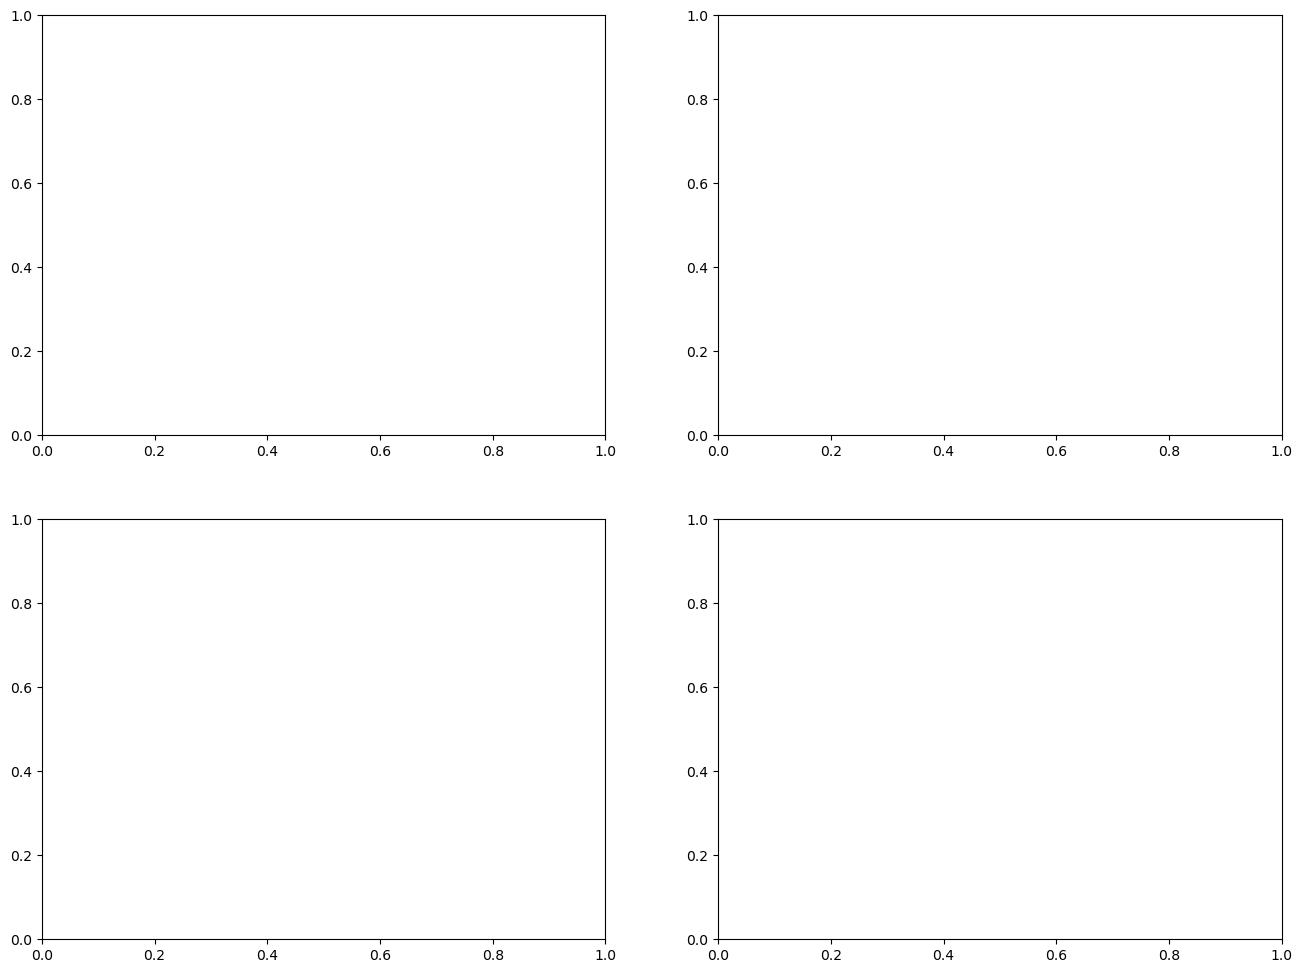

In [34]:
# Comprehensive Model Comparison Chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Collect all model results - combine full feature and top feature models
all_models = {
    'RF (Full Features)': rf_results,
    'XGBoost (Full)': xgb_results if xgb_clf is not None else None,
    'LR (Full)': lr_results,
}

# Add top feature model results
for name, result in top_feature_results.items():
    all_models[f'{name} (Top {ML.TOP_N_FEATURES})'] = {
        'accuracy': result['accuracy'],
        'f1_macro': result['f1_macro'],
        'f1_weighted': result['f1_weighted'],
    }

# Add TabPFN if available
if TABPFN_AVAILABLE:
    all_models[f'TabPFN (Top {ML.TOP_N_FEATURES})'] = tabpfn_results

# Remove None entries
all_models = {k: v for k, v in all_models.items() if v is not None}

# Sort by accuracy
sorted_all = sorted(all_models.items(), key=lambda x: x[1]['accuracy'], reverse=True)
model_names = [m[0] for m in sorted_all]
accuracies = [m[1]['accuracy'] for m in sorted_all]
f1_scores = [m[1]['f1_macro'] for m in sorted_all]

# Plot 1: Horizontal bar chart - Top 10 models by accuracy
top_10 = sorted_all[:10]
top_10_names = [m[0] for m in top_10]
top_10_acc = [m[1]['accuracy'] for m in top_10]
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_10)))

bars = axes[0, 0].barh(top_10_names[::-1], top_10_acc[::-1], color=colors[::-1], edgecolor='black')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Top 10 Models by Accuracy')
axes[0, 0].set_xlim(0, 1.1)
axes[0, 0].grid(axis='x', linestyle='--', alpha=0.7)
for bar, acc in zip(bars, top_10_acc[::-1]):
    axes[0, 0].text(acc + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{acc:.3f}', ha='left', va='center', fontsize=8)

# Plot 2: Grouped bar for top 6 models
top_6 = sorted_all[:6]
x_pos = np.arange(len(top_6))
width = 0.35
top_6_names = [m[0] for m in top_6]
top_6_acc = [m[1]['accuracy'] for m in top_6]
top_6_f1 = [m[1]['f1_macro'] for m in top_6]

bars1 = axes[0, 1].bar(x_pos - width/2, top_6_acc, width, label='Accuracy', color='steelblue')
bars2 = axes[0, 1].bar(x_pos + width/2, top_6_f1, width, label='F1 (macro)', color='coral')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Top 6 Models: Accuracy vs F1')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(top_6_names, rotation=30, ha='right', fontsize=8)
axes[0, 1].legend()
axes[0, 1].set_ylim(0, 1.15)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: Full vs Top Features comparison for same model types
model_types = ['Random Forest', 'XGBoost', 'Logistic Regression']
full_acc = []
top_acc = []
for mt in model_types:
    # Find full version
    full_key = [k for k in all_models.keys() if mt in k and 'Full' in k]
    top_key = [k for k in all_models.keys() if mt in k and f'Top {ML.TOP_N_FEATURES}' in k]
    if full_key:
        full_acc.append(all_models[full_key[0]]['accuracy'])
    else:
        full_acc.append(0)
    if top_key:
        top_acc.append(all_models[top_key[0]]['accuracy'])
    else:
        top_acc.append(0)

x = np.arange(len(model_types))
width = 0.35
axes[1, 0].bar(x - width/2, full_acc, width, label='Full Features', color='royalblue')
axes[1, 0].bar(x + width/2, top_acc, width, label=f'Top {ML.TOP_N_FEATURES} Features', color='orange')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Full vs Top Features: Same Model Comparison')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(model_types)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1.1)
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 4: Best model confusion matrix
best_name, best_result = sorted_all[0]
if best_name in top_feature_results:
    cm_best = top_feature_results[best_name.replace(f' (Top {ML.TOP_N_FEATURES})', '')]['confusion_matrix']
elif 'TabPFN' in best_name and TABPFN_AVAILABLE:
    cm_best = confusion_matrix(y_test_encoded, tabpfn_results['y_pred'])
else:
    cm_best = cm_full

im = axes[1, 1].imshow(cm_best, cmap='Blues')
axes[1, 1].set_title(f'Best Model: {best_name}\n(Accuracy: {best_result["accuracy"]:.4f})')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_xticks(range(len(le.classes_)))
axes[1, 1].set_yticks(range(len(le.classes_)))
axes[1, 1].set_xticklabels(le.classes_)
axes[1, 1].set_yticklabels(le.classes_)
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        axes[1, 1].text(j, i, cm_best[i, j], ha='center', va='center',
                       color='white' if cm_best[i, j] > cm_best.max()/2 else 'black', fontsize=12)
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

# Print comprehensive summary table
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON SUMMARY")
print("="*80)
print(f"{'Rank':<5} {'Model':<40} {'Accuracy':<12} {'F1 (macro)':<12}")
print("-"*80)
for rank, (name, result) in enumerate(sorted_all[:15], 1):
    print(f"{rank:<5} {name:<40} {result['accuracy']:<12.4f} {result['f1_macro']:<12.4f}")
print("="*80)
print(f"\n🏆 BEST MODEL: {sorted_all[0][0]}")
print(f"   Accuracy: {sorted_all[0][1]['accuracy']:.4f}")
print(f"   F1 (macro): {sorted_all[0][1]['f1_macro']:.4f}")

## Step 9: Save Models

In [ ]:
# Create output directory
output_dir = ensure_dir(PATHS.ML_MODELS_DIR)

# Save full feature models
save_model(
    rf, output_dir / "random_forest_full.pkl",
    metadata={"n_features": len(feature_names), "accuracy": rf_results["accuracy"]},
)

save_model(
    lr, output_dir / "logistic_regression_full.pkl",
    metadata={"accuracy": lr_results["accuracy"]},
)

if xgb_clf is not None:
    save_model(
        xgb_clf, output_dir / "xgboost_full.pkl",
        metadata={"accuracy": xgb_results["accuracy"]},
    )

# Save top feature models
for name, result in top_feature_results.items():
    safe_name = name.lower().replace(' ', '_').replace('(', '').replace(')', '')
    save_model(
        result['model'], output_dir / f"{safe_name}_top{ML.TOP_N_FEATURES}.pkl",
        metadata={"n_features": ML.TOP_N_FEATURES, "accuracy": result["accuracy"]},
    )

# Save TabPFN if available
if TABPFN_AVAILABLE:
    save_model(
        tabpfn, output_dir / f"tabpfn_top{ML.TOP_N_FEATURES}.pkl",
        metadata={"n_features": ML.TOP_N_FEATURES, "accuracy": tabpfn_results["accuracy"]},
    )

# Save feature importance
rf_importance.to_csv(output_dir / "feature_importances.csv", index=False)

# Save top features list
top_feature_df = rf_importance.head(ML.TOP_N_FEATURES)
top_feature_df.to_csv(output_dir / f"top_{ML.TOP_N_FEATURES}_features.csv", index=False)

# Save comprehensive model comparison results
comparison_results = pd.DataFrame([
    {"model": k, "accuracy": v["accuracy"], "f1_macro": v["f1_macro"]}
    for k, v in sorted(all_models.items(), key=lambda x: x[1]['accuracy'], reverse=True)
])
comparison_results.to_csv(output_dir / "model_comparison.csv", index=False)

print(f"\nAll models saved to: {output_dir}")
print(f"\nFull Feature Models:")
print(f"  - random_forest_full.pkl")
print(f"  - logistic_regression_full.pkl")
if xgb_clf is not None:
    print(f"  - xgboost_full.pkl")
print(f"\nTop {ML.TOP_N_FEATURES} Feature Models:")
for name in top_feature_results.keys():
    safe_name = name.lower().replace(' ', '_').replace('(', '').replace(')', '')
    print(f"  - {safe_name}_top{ML.TOP_N_FEATURES}.pkl")
if TABPFN_AVAILABLE:
    print(f"  - tabpfn_top{ML.TOP_N_FEATURES}.pkl")
print(f"\nData Files:")
print(f"  - feature_importances.csv")
print(f"  - top_{ML.TOP_N_FEATURES}_features.csv")
print(f"  - model_comparison.csv")

Model saved to: output/ml_models/random_forest_full.pkl
Model saved to: output/ml_models/random_forest_top25.pkl
Model saved to: output/ml_models/logistic_regression.pkl
Model saved to: output/ml_models/xgboost.pkl

All models saved to: output/ml_models


## Summary

In [ ]:
# Find best model from all trained models
best_model_name, best_model_result = sorted_all[0]

print("="*70)
print("ML TRAINING SUMMARY")
print("="*70)
print(f"\nData:")
print(f"  Total Samples: {len(X)}")
print(f"  Total Features: {len(feature_names)}")
print(f"  Top Features Used: {ML.TOP_N_FEATURES}")
print(f"  Classes: {len(le.classes_)} ({list(le.classes_)})")
print(f"\nModels Trained: {len(all_models)}")
print(f"  Full Feature Models: 3 (RF, XGBoost, LR)")
print(f"  Top Feature Models: {len(top_feature_results)} + TabPFN")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {best_model_result['accuracy']:.4f}")
print(f"   F1 (macro): {best_model_result['f1_macro']:.4f}")

print(f"\nTop 5 Models:")
for rank, (name, result) in enumerate(sorted_all[:5], 1):
    print(f"  {rank}. {name}: {result['accuracy']:.4f}")

print(f"\nModels saved to: {output_dir}")
print(f"\nNext step: Run 05_model_evaluation.ipynb for detailed analysis")

ML TRAINING SUMMARY

Data:
  Samples: 306
  Features: 2637
  Classes: 3 (['CHB', 'JPT', 'KHV'])

Best Model: Random Forest
  Full features accuracy: 1.0000
  Top 25 features accuracy: 0.7742

Models saved to: output/ml_models

Next step: Run 05_model_evaluation.ipynb for detailed analysis
